In [9]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from gripper_filter import detect_gripper_transitions
from run_uvd import display_subgoals_grid
import os
import joblib
import re
import multiprocessing as mp
from tqdm import tqdm
from convert_joblib_to_mp4 import save_video_from_arrays
from functools import partial
#

In [6]:
directory = "/home/asjchoi/datasets/bridge/train/"
save_directory = "/home/asjchoi/datasets/bridge/"

verb_filter = ["put",
               "move",
               "putting",
               "moved",
               "pick",
               "place",
               "take"]
verb_patterns = [re.compile(r'\b' + verb + r'\b') for verb in verb_filter]

image_key = "image_0"

all_files =  sorted(os.listdir(directory), key=lambda x: int(x.split(".joblib.gz")[0].split("episode_")[1]))

num_files = 0
total_files = len(all_files)

target_files = ['episode_29567.joblib.gz', 'episode_21589.joblib.gz', 'episode_38426.joblib.gz', 'episode_38263.joblib.gz', 'episode_32028.joblib.gz', 'episode_52245.joblib.gz', 'episode_36016.joblib.gz', 'episode_8276.joblib.gz', 'episode_13810.joblib.gz', 'episode_18060.joblib.gz', 'episode_31573.joblib.gz', 'episode_45556.joblib.gz', 'episode_6703.joblib.gz', 'episode_38006.joblib.gz', 'episode_38419.joblib.gz', 'episode_40774.joblib.gz', 'episode_42625.joblib.gz', 'episode_38563.joblib.gz', 'episode_3676.joblib.gz', 'episode_29161.joblib.gz']

# for i, fn in enumerate(all_files[:40]):
for i, fn in enumerate(target_files):
    data = joblib.load(directory + fn)

    frames = []
    states = []
    actions = []
    language = data['steps'][0]['language_instruction'].decode('utf-8').lower()

    for time_step in data['steps']:
        obs = time_step['observation']
        img = obs[image_key]
        frames.append(img)
        states.append(obs['state'])
        actions.append(time_step['action'])


    # frames = np.array(frames)
    actions = np.array(actions)
    states = np.array(states)

    gripper_actions = actions[:, -1]

    # We want to exclude any episodes that don't involve using the gripper,
    # since we won't be able to decompose it.
    if np.all(gripper_actions == 1):
        continue

    # Make sure the language instruction involves some sort of pick and place meaning.
    # This will also help filter out corrupted data.
    if not any(pattern.search(language) for pattern in verb_patterns):
        continue

    num_files +=1

    prefix = fn.split(".joblib.gz")[0]
    new_data_name = prefix + ".npz"
    new_video_name = prefix + ".mp4"
    np.savez(save_directory + new_data_name,
             frames=frames,
             actions=actions,
             states=states,
             language=language)
    save_video_from_arrays(frames, save_directory + new_video_name, fps=5)  # bridge uses 5 Hz control

    print(f"Saved {num_files} files out of {i+1}. Ratio of saved files: {num_files / (i+1)}")

print(f"Saved {num_files} files out of {total_files}. Ratio of saved files: {num_files / total_files}")


Video saved to /home/asjchoi/datasets/bridge/episode_29567.mp4
Saved 1 files out of 1. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_21589.mp4
Saved 2 files out of 2. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_38426.mp4
Saved 3 files out of 3. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_38263.mp4
Saved 4 files out of 4. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_32028.mp4
Saved 5 files out of 5. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_52245.mp4
Saved 6 files out of 6. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_36016.mp4
Saved 7 files out of 7. Ratio of saved files: 1.0
Video saved to /home/asjchoi/datasets/bridge/episode_13810.mp4
Saved 8 files out of 9. Ratio of saved files: 0.8888888888888888
Video saved to /home/asjchoi/datasets/bridge/episode_18060.mp4
Saved 9 files out 

### Filtering Bridge Data based on Language Instructions + Gripper Signal

Using a verb list filter as well as gripper signal filter, we will get a subset of the bridge dataset that has more pick and place-oriented tasks. In other words, we want to avoid any tasks such as "pushing" or "folding".

We make sure to use multiprocessing for this as the dataset is quite large.

In [6]:
def process_file(fn, directory, verb_patterns):
    """Process a single file and extract relevant information if it meets criteria.

    Args:
        fn: Filename to process
        directory: Directory containing the file
        verb_patterns: Compiled regex patterns to match in language instructions

    Returns:
        Tuple of (filename, actions, language) if file meets criteria, None otherwise
    """
    try:
        data = joblib.load(os.path.join(directory, fn))

        # Extract language from first step
        language = data['steps'][0]['language_instruction'].decode('utf-8').lower()

        # Skip if no matching verb pattern
        if not any(pattern.search(language) for pattern in verb_patterns):
            return None

        # Extract actions more efficiently
        actions = np.array([step['action'] for step in data['steps']])

        # Skip if gripper never moves (all values are 1)
        gripper_actions = actions[:, -1]
        if np.all(gripper_actions == 1):
            return None

        return (fn, actions, language)

    except Exception as e:
        print(f"Error processing {fn}: {e}")
        return None

# Configuration
directory = "/home/asjchoi/datasets/bridge/train/"
save_directory = "/home/asjchoi/datasets/bridge/"

# Verb pattern compilation (moved outside the loop)
verb_filter = ["put", "putting",
               "move", "moved", "moves",
               "pick", "pickup", "picked",
               "place",
               "take",
               "remove",
               "flip"]
verb_patterns = [re.compile(r'\b' + verb + r'\b') for verb in verb_filter]

# Get sorted files
all_files = sorted(
    os.listdir(directory),
    key=lambda x: int(x.split(".joblib.gz")[0].split("episode_")[1])
)
total_files = len(all_files)
print(f"Processing {total_files} files...")

# Use all available cores or cap at 24
num_processes = min(mp.cpu_count(), 26)

# Create partial function with fixed arguments
process_func = partial(process_file, directory=directory, verb_patterns=verb_patterns)

# Process files in parallel with progress bar
results = []
valid_count = 0

with mp.Pool(processes=num_processes) as pool:
    # Use tqdm to show progress
    with tqdm(total=total_files) as pbar:
        for i, result in enumerate(pool.imap_unordered(process_func, all_files), 1):
            pbar.update(1)

            if result is not None:
                results.append(result)
                valid_count = len(results)
                ratio = valid_count / i
                pbar.set_description(f"Valid files: {valid_count} (ratio: {ratio:.3f})")

# Report results
print(f"Final: Saved {valid_count} files out of {total_files}. "
      f"Ratio of saved files: {valid_count/total_files:.3f}")

# Save the filtered results to a text file with one filename per row
output_file = os.path.join(save_directory, "filtered_files.txt")
with open(output_file, 'w') as f:
    for result in results:
        filename = result[0]  # Extract just the filename from the result tuple
        f.write(f"{filename}\n")

print(f"Saved filenames to {output_file}")

Processing 38660 files...


Valid files: 24960 (ratio: 0.646): 100%|██████████| 38660/38660 [01:27<00:00, 440.37it/s]


Final: Saved 24960 files out of 38660. Ratio of saved files: 0.646
Saved filenames to /home/asjchoi/datasets/bridge/filtered_files.txt


In [26]:
def process_file(fn, data_directory, save_directory, verb_patterns):
    """Process a single file and extract relevant information if it meets criteria.

    Args:
        fn: Filename to process
        data_directory: Directory containing the file
        save_directory: Directory to save the new one in
        verb_patterns: Compiled regex patterns to match in language instructions

    Returns:
        Tuple of (filename, actions, language) if file meets criteria, None otherwise
    """
    try:
        data = joblib.load(os.path.join(data_directory, fn))

        # Extract language from first step
        language = data['steps'][0]['language_instruction'].decode('utf-8').lower()

        # Skip if no matching verb pattern
        if not any(pattern.search(language) for pattern in verb_patterns):
            return None

        # Extract actions more efficiently
        actions = np.array([step['action'] for step in data['steps']])

        # Skip if gripper never moves (all values are 1)
        gripper_actions = actions[:, -1]
        if np.all(gripper_actions == 1):
            return None

        states = np.array([step['observation']['state'] for step in data['steps']])
        gripper_states = states[:, -1]

        subgoal_indices, gripper_signal = detect_gripper_transitions(gripper_states, window_size=3, threshold=5e-2, invert_state=True)
        subgoal_indices -= 1

        # This should never happen, but just in case, throw it away.
        if len(subgoal_indices) > 2 or len(subgoal_indices) == 0:
            return None

        # Sometimes the video ends as soon as ungrasp. Check for this.
        # If there is never an ungrasp, throw it away.
        if len(subgoal_indices) == 1:
            if gripper_states[-1] < 0.90:
                return None

        subgoal_start_end_indices = []
        subgoal_start_end_indices.append((0, subgoal_indices[0]))
        if len(subgoal_indices) == 1:
            subgoal_start_end_indices.append((subgoal_indices[0]+1, actions.shape[0]-1))
        else:  # must be 2
            subgoal_start_end_indices.append((subgoal_indices[0]+1, subgoal_indices[1]))
            subgoal_start_end_indices.append((subgoal_indices[1]+1, actions.shape[0]-1))

        data["subgoal_indices"] = subgoal_indices
        joblib.dump(data, os.path.join(save_directory, fn), compress=('gzip', 3))

        return fn

    except Exception as e:
        print(f"Error processing {fn}: {e}")
        return None

# Configuration
# data_directory = "/home/asjchoi/datasets/bridge/train/"
data_directory = "/home/asjchoi/datasets/bridge/val/"
# save_directory = "/home/asjchoi/datasets/bridge_unambig/train"
save_directory = "/home/asjchoi/datasets/val/"

# Verb pattern compilation (moved outside the loop)
verb_filter = ["put", "putting",
               "move", "moved", "moves",
               "pick", "pickup", "picked",
               "place",
               "take",
               "remove",
               "flip",
               "open",
               "pull"]
verb_patterns = [re.compile(r'\b' + verb + r'\b') for verb in verb_filter]

# Get sorted files
all_files = sorted(
    os.listdir(data_directory),
    key=lambda x: int(x.split(".joblib.gz")[0].split("episode_")[1])
)
total_files = len(all_files)
print(f"Processing {total_files} files...")

# Use all available cores or cap at 24
num_processes = min(mp.cpu_count(), 26)

# Create partial function with fixed arguments
process_func = partial(process_file,
                       data_directory=data_directory,
                       save_directory=save_directory,
                       verb_patterns=verb_patterns)

# Process files in parallel with progress bar
valid_files = []
valid_count = 0

with mp.Pool(processes=num_processes) as pool:
    # Use tqdm to show progress
    with tqdm(total=total_files) as pbar:
        for i, result in enumerate(pool.imap_unordered(process_func, all_files), 1):
            pbar.update(1)

            if result is not None:
                fn = result
                valid_files.append(fn)
                valid_count = len(valid_files)
                ratio = valid_count / i
                pbar.set_description(f"Valid files: {valid_count} (ratio: {ratio:.3f})")

# Report results
print(f"Final: Saved {valid_count} files out of {total_files}. "
      f"Ratio of saved files: {valid_count/total_files:.3f}")

# # Save the filtered results to a text file with one filename per row
# output_file = os.path.join(save_directory, "filtered_files.txt")
# with open(output_file, 'w') as f:
#     for fn in valid_files:
#         f.write(f"{fn}\n")
#
# print(f"Saved filenames to {output_file}")


Processing 5147 files...


Valid files: 2784 (ratio: 0.541): 100%|██████████| 5147/5147 [00:35<00:00, 146.04it/s]


Final: Saved 2784 files out of 5147. Ratio of saved files: 0.541


### Applying Gripper Filter to get decomposition


In [5]:
valid_data_files = os.path.join("/home/asjchoi/datasets/bridge/filtered_train_files.txt")

with open(valid_data_files, "r") as f:
    valid_data_fns = f.read().splitlines()

almost_valid_data_files = os.path.join("/home/asjchoi/datasets/bridge/filtered_files.txt")

with open(almost_valid_data_files, "r") as f:
    almost_valid_data_fns = f.read().splitlines()

failed_data = list(set(valid_data_fns) - set(almost_valid_data_fns))

print(failed_data[:20])



# save_directory = "/home/asjchoi/datasets/bridge_unambig/train/"
# for fn in valid_data_fns:
#     data = joblib.load(os.path.join(data_directory + fn))
#
#     for
#
#     print(fn)

['episode_29567.joblib.gz', 'episode_21589.joblib.gz', 'episode_38426.joblib.gz', 'episode_38263.joblib.gz', 'episode_32028.joblib.gz', 'episode_52245.joblib.gz', 'episode_36016.joblib.gz', 'episode_8276.joblib.gz', 'episode_13810.joblib.gz', 'episode_18060.joblib.gz', 'episode_31573.joblib.gz', 'episode_45556.joblib.gz', 'episode_6703.joblib.gz', 'episode_38006.joblib.gz', 'episode_38419.joblib.gz', 'episode_40774.joblib.gz', 'episode_42625.joblib.gz', 'episode_38563.joblib.gz', 'episode_3676.joblib.gz', 'episode_29161.joblib.gz']


In [ ]:

data_path = "/home/asjchoi/datasets/bridge/episode_38419.npz"

Language: pick up sponge and wipe plate
1
[12]


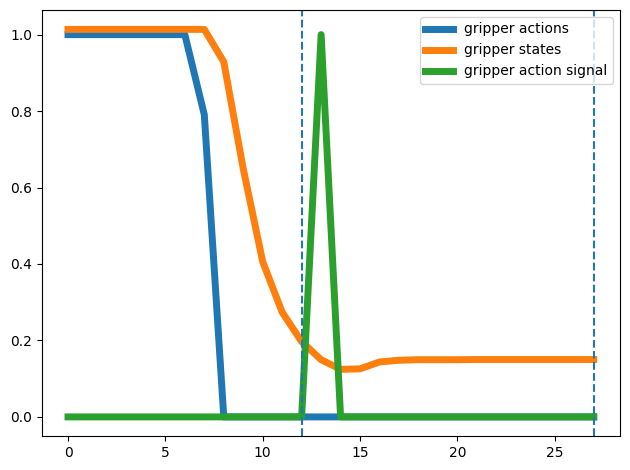

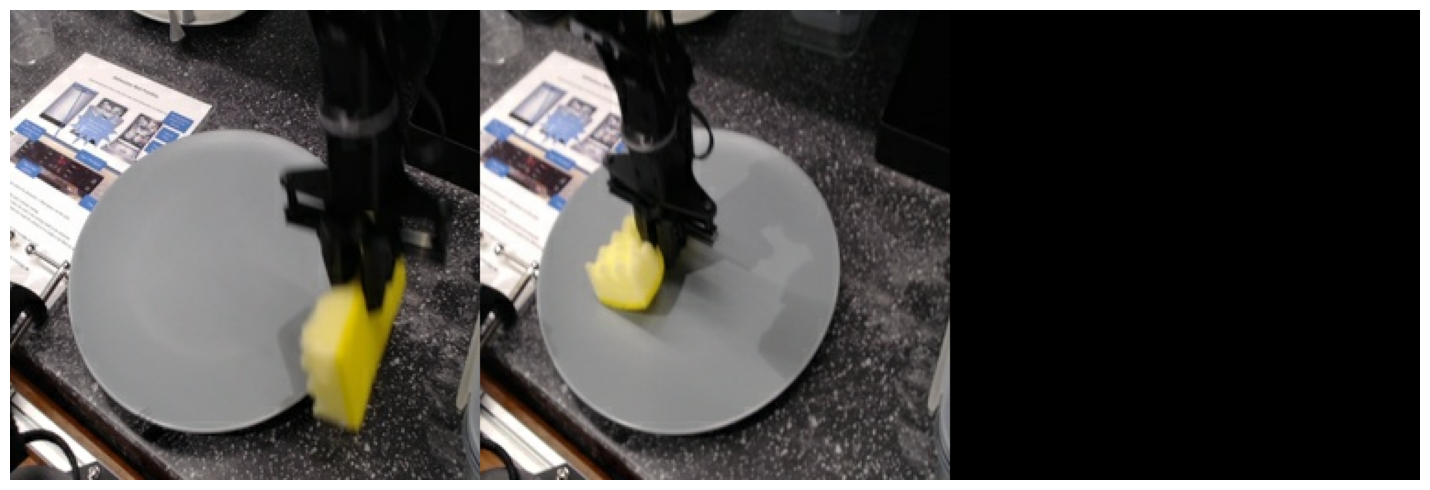

In [22]:
data_path = "/home/asjchoi/datasets/bridge/episode_38419.npz"

data = np.load(data_path)
frames = data['frames']
states = data['states']
actions = data['actions']
language = data['language'].item()
print(f"Language: {language}")

x = np.arange(actions.shape[0])

gripper_states = states[:, -1]
gripper_actions = actions[:, -1]
# gripper_indices, gripper_signal = detect_gripper_transitions(gripper_actions, window_size=3,
#                                                              threshold=5e-2, invert_state=True)
gripper_indices, gripper_signal = detect_gripper_transitions(gripper_states, window_size=3,
                                                             threshold=5e-2, invert_state=True)
gripper_indices += -1

print(len(gripper_indices))

print(gripper_indices)

plt.figure()
plt.plot(x, gripper_actions, label="gripper actions", linewidth=5)
plt.plot(x, gripper_states, label="gripper states", linewidth=5)
plt.plot(x, gripper_signal, label="gripper action signal", linewidth=5)

indices = list(gripper_indices)
indices.append(len(gripper_actions) - 1)
indices = np.array(indices)

for i in indices:
    plt.axvline(x=i, linestyle="--")
plt.tight_layout()
plt.legend(fontsize=10)


display_subgoals_grid(frames[indices])
